<a href="https://colab.research.google.com/github/SamuelSuaV/Cocktail-RAG/blob/main/Cocktail_RAG_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de un RAG de Recetas de Cocteles

## 0. Setup Inicial

In [3]:
# Instalacion de paquetes de Hugging Face
!pip install -U --quiet "transformers>=4.44.0" "accelerate>=0.33.0" "bitsandbytes>=0.43.1" "peft>=0.12.0" sentencepiece
!pip install -U --quiet --no-cache-dir bitsandbytes

import os, sys, time
print("Reiniciando el runtime para activar bitsandbytes…")
#time.sleep(1)
#os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.1 MB/s eta 0:00:00
Reiniciando el runtime para activar bitsandbytes…


In [4]:
# Stack para construir RAG
!pip -q install langchain langchain-community langchain-text-splitters faiss-cpu sentence-transformers ragas unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.7/366.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.8/358.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226

In [5]:
# Otras importaciones
import pandas as pd
import re
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from textwrap import shorten
import matplotlib.pyplot as plt

# 1. Importación de base de datos


In [6]:
# Tomamos la base de Hugging Face
cocktails = pd.read_parquet("hf://datasets/brianarbuckle/cocktail_recipes/data/train-00000-of-00001-dcec52ec7fe8275d.parquet")
columns = ['title', 'ingredients', 'directions', 'misc', 'source', 'ner']

cocktails = cocktails[(~cocktails['ingredients'].isna()) & (~cocktails['directions'].isna())][columns].reset_index(drop=True)
cocktails

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"
...,...,...,...,...,...,...
870,Yellow Bird,"[ A Caribbean favorite., 1 ounce dark rum, 1 o...","[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[galliano, triple sec, rum, cointreau]"
871,Yellow Fever,"[1 1/2 ounces vodka, 1/2 ounce Galliano, 1/2 o...","[Shake ingredients with ice., Strain into a ch...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[vodka, galliano]"
872,Yellow Parrot Cocktail,"[3/4 ounce yellow Chartreuse, 3/4 ounce Pernod...","[Shake ingredients with ice., Strain into a ch...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[brandy, pernod, chartreuse]"
873,[The Spirit of the] Algonquin,"[ 2oz. 90 Proof Rye, .75oz. Lemon Juice, .75oz...",[shake on ice and strain],[Suggested glassware is Cocktail Glass],PDT,[]


# 2. Normalización de las columnas (listas/arrays → texto)

In [9]:
def list_to_str(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return ", ".join(str(i) for i in x if str(i).strip())

    if x is None:
        return ""
    try:
        if pd.isna(x):
            return ""
    except:
        pass
    return str(x)

In [10]:
cocktails["ingredients_str"] = cocktails["ingredients"].apply(list_to_str)
cocktails["directions_str"]  = cocktails["directions"].apply(list_to_str)
cocktails["misc_str"]        = cocktails["misc"].apply(list_to_str)
cocktails["ner_str"]         = cocktails["ner"].apply(list_to_str)

Verificamos la longitud de las recetas (la columna más larga) para determinar si debemos hacer chunking. Vemos que la longitud promedio es de 50.02 palabras y la máxima es de 367 palabras, lo cual muestra que nuestros documentos son en su mayoría cortos, aunque algunos superan el límite de tokens que tenemos presupuestado. Por lo tanto, eliminamos aquellos documentos que superan las 210 palabras.

La longitud promedio del texto combinado (número de palabras) es: 50.02
La longitud máxima del texto combinado (número de palabras) es: 367
Textos que superan las 210 palabras: 3


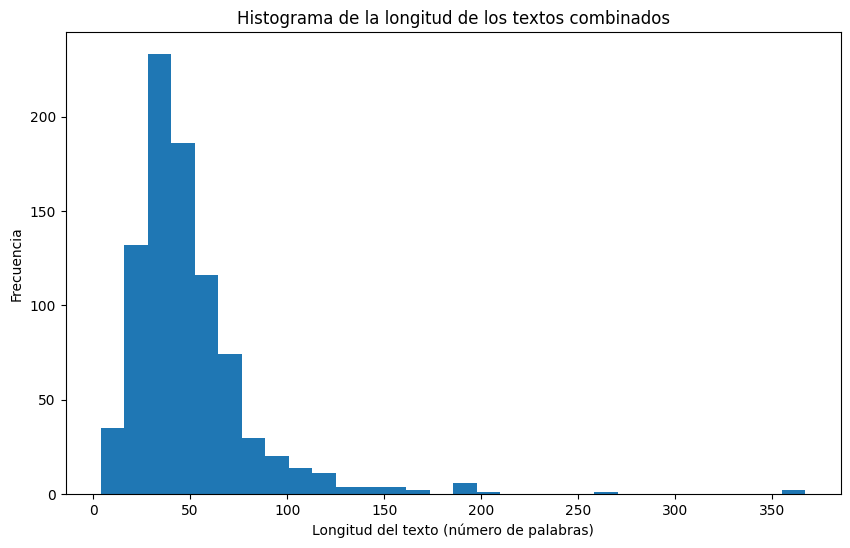

In [22]:
# Concatenamos todas las columnas
cocktails['combined_text'] = cocktails.apply(lambda row:
    f"{row['title']} {row['ingredients_str']} {row['directions_str']} {row['misc_str']} {row['ner_str']} {row['source']}", axis=1)

# Longitud promedio del texto combinado
average_combined_text_length_words = cocktails['combined_text'].apply(lambda x: len(x.split())).mean()
print(f"La longitud promedio del texto combinado (número de palabras) es: {average_combined_text_length_words:.2f}")

# Longitud máxima del texto combinado
max_combined_text_length_words = cocktails['combined_text'].apply(lambda x: len(x.split())).max()
print(f"La longitud máxima del texto combinado (número de palabras) es: {max_combined_text_length_words}")


# Calculamos la longitud en palabras de cada texto
cocktails['combined_text_length'] = cocktails['combined_text'].apply(lambda x: len(x.split()))

num_mayores_210 = (cocktails['combined_text_length'] > 210).sum()
print(f"Textos que superan las 210 palabras: {num_mayores_210}")

# Histograma
plt.figure(figsize=(10,6))
plt.hist(cocktails['combined_text_length'], bins=30)
plt.xlabel("Longitud del texto (número de palabras)")
plt.ylabel("Frecuencia")
plt.title("Histograma de la longitud de los textos combinados")
plt.show()



In [23]:
# Eliminamos los documentos con más de 210 palabras:
cocktails = cocktails[cocktails['combined_text_length'] <= 210].copy()

# 3. Construcción del texto unificado por cóctel

El encoder necesita un solo texto por documento. Aquí combinamos:
- título,
- ingredientes,
- instrucciones,
- notas (`misc`),
- ingredientes clave (`ner`),
- y la fuente;

en una sola columna llamada `text`, que será la entrada al modelo de embeddings.

In [ ]:
# Filtrar para quedarte solo con los textos de 210 palabras o menos
cocktails = cocktails[cocktails['combined_text_length'] <= 210].copy()def row_to_text(row):
    return (
        f"Title: {row['title']}\n"
        f"Ingredients: {row['ingredients_str']}\n"
        f"Directions: {row['directions_str']}\n"
        f"Misc: {row['misc_str']}\n"
        f"Key ingredients: {row['ner_str']}\n"
        f"Source: {row['source']}"
    )

cocktails["text"] = cocktails.apply(row_to_text, axis=1)

cocktails[["title", "text"]].head()

# 4. Encoder elegido: `sentence-transformers/all-MiniLM-L6-v2`

Usamos un **Sentence Transformer** open source (`all-MiniLM-L6-v2`) como encoder de texto a vector.

Características técnicas importantes:
- Está basado en **MiniLM**, un Transformer pequeño y eficiente (6 capas).
- Soporta **hasta 256 tokens** de entrada por texto.
- Produce un **embedding de 384 dimensiones** por cada texto completo.
- Usa *mean pooling*: promedia los embeddings de todos los tokens para obtener un solo vector por cóctel.
- Está publicado bajo licencia **Apache 2.0**, lo que permite su uso en proyectos académicos y aplicaciones prácticas.

Este encoder convierte cada receta de cóctel en un vector numérico que captura su significado.
Luego estos vectores se usan para búsqueda semántica con FAISS dentro del RAG.

In [ ]:
#Encoder Elegido
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"

#Import del Encoder
encoder = HuggingFaceEmbeddings(
    model_name=embedding_model_name
)

# Textos y metadata
texts = cocktails["text"].tolist()
metadatas = cocktails[["title", "source"]].to_dict(orient="records")

# Vectorstore FAISS (parte R de RAG)
vectorstore = FAISS.from_texts(
    texts=texts,
    embedding=encoder,
    metadatas=metadatas
)

vectorstore

In [ ]:
# Análisis Dimensional
lista = cocktails["text"].tolist()
cadena_mas_larga = mas_larga = max(lista, key=len)
print("La cadena más larga es:")
print(cadena_mas_larga)

print("\nEmbedding Cadena Más Larga:\n", encoder.embed_query(cadena_mas_larga))
print(f"\nDimensiones del Embedding: (1x{len(encoder.embed_query(cadena_mas_larga))})")
print(f"Tamaño Matriz de Embeddings: ({vectorstore.index.ntotal}x{len(encoder.embed_query(cadena_mas_larga))})")

# 6. Búsqueda semántica de cócteles (parte R de RAG)

En esta parte hacemos una consulta de ejemplo. El flujo es:

1. El usuario escribe un texto (`query`) describiendo lo que quiere.
2. El encoder convierte `query` en un embedding.
3. FAISS compara ese embedding con todos los cócteles y devuelve los `k` más similares.
4. Mostramos el título, la fuente y un fragmento del texto de cada resultado.

Luego, estos `docs` serían el **contexto** que se le pasa a un modelo generativo
para construir la respuesta final (parte G de RAG).


In [ ]:
query = "sweet cocktail with rum and pineapple"
docs = vectorstore.similarity_search(query, k=3)
for i, d in enumerate(docs, start=1):
    print(f"\n=== Result {i} ===")
    print("Title:", d.metadata.get("title"))
    print("Source:", d.metadata.get("source"))
    print("Snippet:\n", d.page_content[:400], "...")

def encoder(query: str):
  docs = vectorstore.similarity_search(query, k=3)
  context_text = "\n\n---\n\n".join([doc.page_content for doc in docs])
  return context_text
print(encoder(query))

# 7. Implementación del decoder

In [ ]:
model_name2 = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForCausalLM.from_pretrained(
      model_name2,
      torch_dtype=torch.float16,
      device_map="auto"
  )

In [ ]:
tokenizer2.pad_token = tokenizer2.eos_token
model2.config.pad_token_id = model2.config.eos_token_id

from transformers import GenerationConfig

def decoder(context, query):
    prompt = f"Contexto:\n{context}\n\nPregunta: {query}\n\nRespuesta:"

    inputs = tokenizer2(prompt, return_tensors="pt").to(model2.device)

    outputs = model2.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        top_p=0.95
    )

    full_output = tokenizer2.decode(outputs[0], skip_special_tokens=True)

    if "Respuesta:" in full_output:
        answer = full_output.split("Respuesta:")[1].strip()
    else:
        answer = full_output

    return answer

#8. Chat con el Modelo

In [ ]:
try:
    while True:
        query = input("Haz una pregunta: ")
        if query.lower() in ["exit", "quit", "salir"]:
            print("Saliendo…")
            break

        context = encoder(query)
        print(decoder(context, query))

except KeyboardInterrupt:
    print("\nEjecución detenida por el usuario.")